In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
import glob
import subprocess
import os
import pandas as pd
import subprocess
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline,CubicSpline,UnivariateSpline,LSQUnivariateSpline
from scipy.signal import savgol_filter,find_peaks
import pickle

sys.path.insert(0, "./helper_functions/")

from preprocess_functions import find_corresponding_s1d_and_ccf,upper_envelope2,open_pickle,find_closest

try:
    get_ipython().__class__.__name__
    injupyternotebook = True

except:
    injupyternotebook = False

In [2]:
if not injupyternotebook:
    star = sys.argv[1]
else:
    star = "Sun"
    #star = "teststar"

In [3]:
inf_name = './stars/'+star+'/input.py'

In [4]:
exec(open(inf_name).read())

In [5]:
sys.path.insert(0, rassine_loc)

#rawdir must exist. dirdir and rassine_res will be created and populated

if not os.path.exists(dirdir):
    os.mkdir(dirdir)
if not os.path.exists(rassine_res):
    os.mkdir(rassine_res)

In [6]:
all_info = pd.DataFrame()


nr_of_orders = 0

if pipname == "DRS_2.3.5" and extract_info:

    #svnr is the unique identifier of the spectrum. file names e.g. Info_1, spec..._1, wave..._1 etc.
    svnr = 0

    #find all e2ds files
    e2ds_files = sorted(glob.glob(rawdir+"/*S2D_A.fits"))
        
    for ii in range(min(len(e2ds_files),number_of_spectra_to_reduce)):

        #choose iith e2ds file and search for corresponding s1d and ccf file
        try:
            #search files
            #is there a skysub file? (s2d/s1d/ccf with sky subtraction)
            skysub_name = e2ds_files[ii].replace("S2D","S2D_SKYSUB")
            if len(glob.glob(skysub_name))>0 and False:
                e2ds_files[ii] = skysub_name

            s1d_file = e2ds_files[ii].replace("S2D","S1D")
            ccf_file = e2ds_files[ii].replace("S2D","CCF")
                
            hdul = fits.open(e2ds_files[ii])
            hdul_s1d = fits.open(s1d_file)
            hdul_ccf = fits.open(ccf_file)
            
            
        except Exception as e:
            #not all necessary files present
            print("Some error here (1_preprocess).", e)
            continue

        if nr_of_orders == 0:
            nr_of_orders = hdul[1].data.shape[0]
            
        general = {}
        
        #needed
        general["rv_ccf"]=(hdul_ccf[0].header["HIERARCH "+sid+" QC CCF RV"])
        general["ccf_fwhm"] = hdul_ccf[0].header["HIERARCH "+sid+" QC CCF FWHM"]
        general["berv"]=(hdul_ccf[0].header["HIERARCH "+sid+" "+pipeline_keyword+" BERV"])
        general["mjd"] = hdul[0].header["MJD-OBS"]

        for snorder in np.arange(1,nr_of_orders+1):
            try:
                general[f"sn{snorder}"] = hdul_ccf[0].header[f"HIERARCH "+sid+f" QC ORDER{snorder} SNR"]
            except:
                general[f"sn{snorder}"] = 0

        
        
        
        
        try:
            general["rv_ccf_error"]=(hdul_ccf[0].header["HIERARCH "+sid+" QC CCF RV ERROR"])
            general["drift"]=0.
            general["e2dsname"]= e2ds_files[ii],
            general["s1dname"]= s1d_file, 
            general["ccfname"]= ccf_file
            general["dateobs"] = hdul[0].header["DATE-OBS"]
            general["ccf_contrast"] = hdul_ccf[0].header["HIERARCH "+sid+" QC CCF CONTRAST"]
            general["rv_ccf_uncorr"]=(hdul_ccf[0].header["HIERARCH "+sid+" "+pipeline_keyword+" CCF RV"])
            general["bjd_ccf"]=(hdul_ccf[0].header["HIERARCH "+sid+" "+pipeline_keyword+" BJD"])
            general["rhk"] = 0
            general["airmass"] = hdul[0].header["AIRMASS"]
            general["el"] = hdul[0].header["EL"]
            general["exptime"] = hdul[0].header["EXPTIME"]
            general["pip_id"] = hdul[0].header["HIERARCH ESO PRO REC1 PIPE ID"]
            general["humidity"] = hdul[0].header["HIERARCH "+sid+" METEO HUMIDITY"]
            general["pressure"] = hdul[0].header["HIERARCH "+sid+" METEO PRESSURE"]
            general["windspeed"] = hdul[0].header["HIERARCH "+sid+" METEO WINDSPEED"]
            general["winddir"] = hdul[0].header["HIERARCH "+sid+" METEO WINDDIR"]
            general["dust"] = hdul[0].header["HIERARCH "+sid+" INS DUST ST"]
            general["mask"] = hdul[0].header["HIERARCH "+sid+" QC CCF MASK"]
            general["CCF_asymmetry"] = hdul[0].header["HIERARCH "+sid+" QC CCF FLUX ASYMMETRY"]
            general["bisector_span"] = hdul[0].header["HIERARCH "+sid+" QC CCF BIS SPAN"]
        except Exception as e:
            print(f"At least one keyword missing. Not critical.",e)
        
        df = pd.DataFrame(general, index=[ii])  


        
        all_info = pd.concat([all_info,df])
        hdul.close()
        hdul_s1d.close()
        hdul_ccf.close()

        print("spectrum id",ii,"iteration",svnr)
        svnr+=1
        
    all_info.to_csv(dirdir+"Info.csv",index=False)

spectrum id 0 iteration 0
spectrum id 1 iteration 1
spectrum id 2 iteration 2
spectrum id 3 iteration 3
spectrum id 4 iteration 4


In [16]:
all_info = pd.DataFrame()

nr_of_orders = 0


if pipname == "DRS_3.7" and extract_info:

    #svnr is the unique identifier of the spectrum. file names e.g. Info_1, spec..._1, wave..._1 etc.
    svnr = 0

    #find all e2ds files
    e2ds_files = sorted(glob.glob(rawdir+"/*e2ds_A.fits"))
    print(f"found {(len(e2ds_files))} files")
    for ii in range(min(len(e2ds_files),number_of_spectra_to_reduce)):

        #choose iith e2ds file and search for corresponding s1d and ccf file
        try:
            #search files
            s1d_file, ccf_file = find_corresponding_s1d_and_ccf(e2ds_files[ii],rawdir)

            hdul = fits.open(e2ds_files[ii])
            hdul_s1d = fits.open(s1d_file)
            hdul_ccf = fits.open(ccf_file)
            
                
            #blaze_file = rawdir+"/"+hdul[0].header["HIERARCH "+sid+" DRS BLAZE FILE"]
            #hdul_blaze = fits.open(blaze_file)
            
        except Exception as e:
            #not all necessary files present
            print("Some error here (1_preprocess).", e)
            continue

        if nr_of_orders == 0:
            nr_of_orders = hdul[0].data.shape[0]
        general = {}
        
        general["rv_ccf"]=(hdul_ccf[0].header["HIERARCH "+sid+" DRS CCF RVC"])
        general["ccf_fwhm"] = hdul_ccf[0].header["HIERARCH "+sid+" DRS CCF FWHM"]
        general["mjd"] = hdul[0].header["MJD-OBS"]
        general["berv"]=(hdul_ccf[0].header["HIERARCH "+sid+" "+pipeline_keyword+" BERV"])
        general["drift"]=(hdul_ccf[0].header["HIERARCH "+sid+" DRS DRIFT RV USED"])

        
        

        for snorder in np.arange(1,nr_of_orders+1):
            try:
                general[f"sn{snorder}"] = hdul_ccf[0].header[f"HIERARCH "+sid+f" DRS SPE EXT SN{snorder}"]
            except:
                general[f"sn{snorder}"] = 0

        try:
            general["rhk"] = hdul[0].header["HIERARCH "+sid+" DRS CAII RHK"]
        except:
            general["rhk"] = 0
            
        try:
            general["rv_ccf_error"]=0
            general["ccf_contrast"] = hdul_ccf[0].header["HIERARCH "+sid+" DRS CCF CONTRAST"]
            general["rv_ccf_uncorr"]=(hdul_ccf[0].header["HIERARCH "+sid+" "+pipeline_keyword+" CCF RV"])
            general["bjd_ccf"]=(hdul_ccf[0].header["HIERARCH "+sid+" "+pipeline_keyword+" BJD"])
            general["airmass"] = hdul[0].header["AIRMASS"]
            general["dateobs"] = hdul[0].header["DATE-OBS"]
            general["el"] = hdul[0].header["EL"]
            general["exptime"] = hdul[0].header["EXPTIME"]
            general["e2dsname"]= e2ds_files[ii],
            general["s1dname"]= s1d_file, 
            general["ccfname"]= ccf_file
        except Exception as e:
            print(f"At least one keyword missing. Not critical.",e)
        
        
        df = pd.DataFrame(general, index=[ii])  
        
        all_info = pd.concat([all_info,df])
        
        hdul.close()
        hdul_s1d.close()
        hdul_ccf.close()

        print("spectrum id",ii,"iteration",svnr)
        svnr+=1
        
    all_info.to_csv(dirdir+"Info.csv",index=False)

In [17]:
info_file = pd.read_csv(dirdir+"Info.csv")

In [9]:
fewerdp=False

if run_rassine:
    if True:
        print("Running RASSINE for ",len(info_file.index)," files")
        for ii in info_file.index:
            os.chdir(rt)
            
            info = info_file.iloc[ii]    
            
            s1d_filename = info["s1dname"]
            with fits.open(s1d_filename) as s1d_fits:
                
                #get s1d data
                if pipname == "DRS_3.7":
                    step = s1d_fits[0].header["CDELT1"]
                    start = s1d_fits[0].header["CRVAL1"]
                    yy = s1d_fits[0].data
                    xx = start + step*np.arange(len(yy))
                if pipname == "DRS_2.3.5":
                    xx = s1d_fits[1].data["wavelength_air"]
                    yy = s1d_fits[1].data["flux"]
                if fewerdp:
                    xx = xx[::2]
                    yy = yy[::2]
                    
                rassine_res_file = rassine_res+"rass_"+str(ii)+".csv"
                #make sure spectrum_name is set to cwd+'/spectra_library/stars/spec_toreduce.csv' in Rassine_config.py.
                temp_name = rassine_res+"spec_toreduce.csv"
                copyto = rassine_loc+"/spectra_library/stars/"
                
                #save to temp_name
                df = pd.DataFrame({"wave": xx,"flux": yy})
                df.to_csv(temp_name,index=False)

                #copy to RASSINE folder
                command = "cp "+temp_name+" "+copyto
                os.system(command)
                
                #run RASSINE          
                
                
                try:
                    os.chdir(rassine_loc)
                    subprocess.call([sys.executable, 'Rassine.py'])
                    
                    #batcmd="python Rassine.py"
                    #output = subprocess.check_output(batcmd, shell=True)
                except Exception as E:
                    print(E)
                    continue
                os.chdir(rt)
                
                #print(output)
                #get RASSINE results
                
                continuum_file = rassine_loc+"/output/RASSINE_spec_toreduce.p"
                continuum_file_open = open_pickle(continuum_file)
                continuum_flux = continuum_file_open["output"]["continuum_linear"]
                continuum_wvl = continuum_file_open["wave"]
                
                #save to separate files in case nomalisation fails for one spectrum
                df = pd.DataFrame({"s1d_wave": xx,"s1d_flux": yy, "continuum_wave": continuum_wvl, "continuum_flux": continuum_flux})
                df.to_csv(rassine_res_file,index=False)
                print(rassine_res_file)
                #command = "rm "+temp_name
                #os.system(command)
                os.remove(temp_name)
                print(ii)

Running RASSINE for  5  files


Rassine.py:316: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalisation = np.float(len_y)/np.float(len_x) # stretch the y axis to scale the x and y axis
/home/fl386/Rassine_public-master/Rassine_functions.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(kept), border
Rassine.py:580: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wi


 [BEGIN] RASSINE is beginning the reduction

 Computation of the local maxima : LOADING
 Spectrum SNR at 5500 : 382
 Number of cosmic peaks removed : 18
 Number of cosmic peaks removed : 2
 Number of cosmic peaks removed : 0
 [AUTO] FWHM computed from the CCF is about : 7.01 [km/s]
 Number of cosmic peaks removed : 2
 Suggestion of a streching parameter to try : 11 +/- 3
 [AUTO] par_stretching fixed : 11.38
 Computation of the local maxima : DONE
 Time of the step : 2.88

 Computation of the penality map : LOADING
 [AUTO] R fixed : 3.8
 [AUTO] Rmax found around 3930 AA and fixed : 78
 Computation of the penality map : DONE
 Time of the step : 2.02

 Rolling pin is rolling : LOADING
 Rolling pin is rolling : DONE
 Time of the step : 0.18

 Edge cutting : LOADING
 Edge cutting : DONE
 Time of the step : 0.00

 Outliers removing : LOADING
 Outliers removing : DONE
 Time of the step : 0.00
 Number of points removed to build a more equidistant grid : 31

 [END] RASSINE has finished to comp

Rassine.py:316: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalisation = np.float(len_y)/np.float(len_x) # stretch the y axis to scale the x and y axis
/home/fl386/Rassine_public-master/Rassine_functions.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(kept), border
Rassine.py:580: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wi


 [BEGIN] RASSINE is beginning the reduction

 Computation of the local maxima : LOADING
 Spectrum SNR at 5500 : 387
 Number of cosmic peaks removed : 21
 Number of cosmic peaks removed : 8
 Number of cosmic peaks removed : 9
 Number of cosmic peaks removed : 4
 Number of cosmic peaks removed : 0
 [AUTO] FWHM computed from the CCF is about : 7.01 [km/s]
 Number of cosmic peaks removed : 1
 Suggestion of a streching parameter to try : 11 +/- 3
 [AUTO] par_stretching fixed : 11.39
 Computation of the local maxima : DONE
 Time of the step : 4.22

 Computation of the penality map : LOADING
 [AUTO] R fixed : 3.8
 [AUTO] Rmax found around 3929 AA and fixed : 76
 Computation of the penality map : DONE
 Time of the step : 1.96

 Rolling pin is rolling : LOADING
 Rolling pin is rolling : DONE
 Time of the step : 0.18

 Edge cutting : LOADING
 Edge cutting : DONE
 Time of the step : 0.00

 Outliers removing : LOADING
 Outliers removing : DONE
 Time of the step : 0.00
 Number of points removed to

Rassine.py:316: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalisation = np.float(len_y)/np.float(len_x) # stretch the y axis to scale the x and y axis
/home/fl386/Rassine_public-master/Rassine_functions.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(kept), border
Rassine.py:580: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wi


 [BEGIN] RASSINE is beginning the reduction

 Computation of the local maxima : LOADING
 Spectrum SNR at 5500 : 393
 Number of cosmic peaks removed : 15
 Number of cosmic peaks removed : 7
 Number of cosmic peaks removed : 1
 Number of cosmic peaks removed : 0
 [AUTO] FWHM computed from the CCF is about : 7.01 [km/s]
 Number of cosmic peaks removed : 1
 Suggestion of a streching parameter to try : 11 +/- 3
 [AUTO] par_stretching fixed : 11.39
 Computation of the local maxima : DONE
 Time of the step : 3.52

 Computation of the penality map : LOADING
 [AUTO] R fixed : 3.8
 [AUTO] Rmax found around 3929 AA and fixed : 76
 Computation of the penality map : DONE
 Time of the step : 2.06

 Rolling pin is rolling : LOADING
 Rolling pin is rolling : DONE
 Time of the step : 0.18

 Edge cutting : LOADING
 Edge cutting : DONE
 Time of the step : 0.00

 Outliers removing : LOADING
 Outliers removing : DONE
 Time of the step : 0.00
 Number of points removed to build a more equidistant grid : 22


Rassine.py:316: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalisation = np.float(len_y)/np.float(len_x) # stretch the y axis to scale the x and y axis
/home/fl386/Rassine_public-master/Rassine_functions.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(kept), border
Rassine.py:580: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wi


 [BEGIN] RASSINE is beginning the reduction

 Computation of the local maxima : LOADING
 Spectrum SNR at 5500 : 386
 Number of cosmic peaks removed : 70
 Number of cosmic peaks removed : 34
 Number of cosmic peaks removed : 24
 Number of cosmic peaks removed : 15
 Number of cosmic peaks removed : 19
 [AUTO] FWHM computed from the CCF is about : 7.00 [km/s]
 Number of cosmic peaks removed : 2
 Suggestion of a streching parameter to try : 11 +/- 3
 [AUTO] par_stretching fixed : 11.39
 Computation of the local maxima : DONE
 Time of the step : 4.25

 Computation of the penality map : LOADING
 [AUTO] R fixed : 3.8
 [AUTO] Rmax found around 3930 AA and fixed : 76
 Computation of the penality map : DONE
 Time of the step : 2.16

 Rolling pin is rolling : LOADING
 Rolling pin is rolling : DONE
 Time of the step : 0.19

 Edge cutting : LOADING
 Edge cutting : DONE
 Time of the step : 0.00

 Outliers removing : LOADING
 Outliers removing : DONE
 Time of the step : 0.00
 Number of points remove

Rassine.py:316: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalisation = np.float(len_y)/np.float(len_x) # stretch the y axis to scale the x and y axis
/home/fl386/Rassine_public-master/Rassine_functions.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(kept), border
Rassine.py:580: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wi


 [BEGIN] RASSINE is beginning the reduction

 Computation of the local maxima : LOADING
 Spectrum SNR at 5500 : 404
 Number of cosmic peaks removed : 13
 Number of cosmic peaks removed : 3
 Number of cosmic peaks removed : 1
 Number of cosmic peaks removed : 0
 [AUTO] FWHM computed from the CCF is about : 7.01 [km/s]
 Number of cosmic peaks removed : 0
 Suggestion of a streching parameter to try : 11 +/- 3
 [AUTO] par_stretching fixed : 11.38
 Computation of the local maxima : DONE
 Time of the step : 3.96

 Computation of the penality map : LOADING
 [AUTO] R fixed : 3.8
 [AUTO] Rmax found around 3930 AA and fixed : 78
 Computation of the penality map : DONE
 Time of the step : 2.19

 Rolling pin is rolling : LOADING
 Rolling pin is rolling : DONE
 Time of the step : 0.19

 Edge cutting : LOADING
 Edge cutting : DONE
 Time of the step : 0.00

 Outliers removing : LOADING
 Outliers removing : DONE
 Time of the step : 0.00
 Number of points removed to build a more equidistant grid : 31


In [10]:
rass_files = sorted(glob.glob(rassine_res+"/*rass*csv"))
assert len(rass_files)==len(info_file.index), "not all files processed by RASSINE"

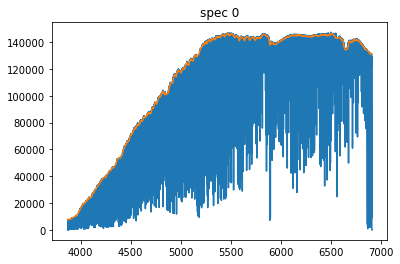

In [11]:
if True:
    ii=np.random.choice(info_file.index)

    plt.title(f"spec {ii}")
    rassine_res_file = rassine_res+"rass_"+str(ii)+".csv"
    res = pd.read_csv(rassine_res_file)
    plt.plot(res["s1d_wave"],res["s1d_flux"])
    plt.plot(res["continuum_wave"],res["continuum_flux"])

In [12]:
if save_spectra_as_pkl and pipname == "DRS_2.3.5":
    ii_no_rassine = []
    
    data_dict = {}
    data_dict["spectrum"] = {}
    #data_dict["spectrum_e2ds"] = {}
    data_dict["wavelengths"] = {}
    data_dict["continuum"] = {}
    data_dict["err"] = {}
    data_dict["err_envelope"] = {}
    
    print("Found",len(info_file.index),"processed spectra")
    
    for ii in info_file.index:
        
        #print(ii)

        info = info_file.iloc[ii]    

        s1d_file = info["s1dname"]
        ccf_file = info["ccfname"]
        e2ds_file = info["e2dsname"]

        hdul = fits.open(e2ds_file)
        hdul_s1d = fits.open(s1d_file)
        hdul_ccf = fits.open(ccf_file)

        rassine_res_file = rassine_res+"rass_"+str(ii)+".csv"
        
        try:
            res = pd.read_csv(rassine_res_file)
            spline = InterpolatedUnivariateSpline(res["continuum_wave"],res["continuum_flux"])
        except:
            print("No RASSINE file for this Info file")
            ii_no_rassine.append(ii)
            continue
        
        flux = hdul[1].data
        lmd = hdul[5].data
        dll = hdul[7].data

        flux_s1dadjusted = np.zeros((np.shape(flux)))
        continuum_s1dadjusted = np.zeros((np.shape(flux)))
        error_envelope_continuum_normalised = np.zeros((np.shape(flux)))
        error_continuum_normalised = hdul[2].data

        for ordr in range(np.shape(lmd)[0]):
            # mimic steps taken in DRS to create s1d from e2ds (except reinterpolation on grid)
            # result: flux level of e2ds same as s1d but on different wavelengths

            fctr = (hdul[0].header["HIERARCH "+sid+" RV STEP"]/c*lmd/dll)[ordr,:]
            flux_s1dadjusted[ordr,:] = flux[ordr,:]*fctr
            
            #-----------------------------------------------------
            #reinterpolate continuum from s1d-rassine to e2ds wavelengths. spline function from above
            continuum_s1dadjusted_o = spline(lmd[ordr,:])
            continuum_s1dadjusted[ordr,:] = continuum_s1dadjusted_o
            
            #-----------------------------------------------------
            #ERROR CALCULATION
            #-----------------------------------------------------

            #ERROR WITH ABSORPTION LINES
            error_continuum_normalised[ordr,:] *= fctr/continuum_s1dadjusted_o

            #-----------------------------------------------------
            #ERROR WITHOUT ABSORPTION LINES

            error_envelope_continuum_normalised[ordr,:] = upper_envelope2(lmd[ordr,:],error_continuum_normalised[ordr,:])

            #-----------------------------------------------------
        
        #now that the rassine-continuum has been reinterpolated on the e2ds wvl grid, we can continuum-normalise
        flux_continuum_normalised = flux_s1dadjusted/continuum_s1dadjusted

        
        #-----------------------------------------------------
        #save as npy bc matrices can be easily stored in this format. 

        data_dict["spectrum"][ii] = flux_continuum_normalised
        #data_dict["spectrum_e2ds"][ii] = flux
        data_dict["wavelengths"][ii] = lmd
        data_dict["continuum"][ii] = continuum_s1dadjusted
        data_dict["err"][ii] = error_continuum_normalised
        data_dict["err_envelope"][ii] = error_envelope_continuum_normalised
        
        #-----------------------------------------------------
        hdul.close()
        hdul_s1d.close()
        hdul_ccf.close()

Found 5 processed spectra


In [13]:

if save_spectra_as_pkl and pipname == "DRS_3.7":
    
    def get_lambda_telluric_frame(hdul):

        # get lambda
        data = hdul[0].data
        # lm = deepcopy(data)
        lm = np.zeros((np.shape(data)))
        d = hdul[0].header["TNG DRS CAL TH DEG LL"]

        for o in range(np.shape(lm)[0]):
            xx = np.arange(len(data[o]))

            # aj = hdul[0].header["TNG DRS CAL TH COEFF LL"+str(jj(o,d,0))]
            # lm[o] = aj * xx**0

            for ii in range(d + 1):
                aj = hdul[0].header["TNG DRS CAL TH COEFF LL" + str(jj(o, d, ii))]
                lm[o] += aj * xx ** ii
            # lm[o] = lm[o]

        return lm

    def jj(o, d, i):
        return o * (d + 1) + i

    def get_flux_and_blaze(hdul, hdul_blaze):
        # not divided by blaze

        flux = hdul[0].data
        blaze = hdul_blaze[0].data

        return flux, blaze
    
    ii_no_rassine = []

    data_dict = {}
    data_dict["spectrum"] = {}
    #data_dict["spectrum_e2ds"] = {}
    data_dict["wavelengths"] = {}
    data_dict["continuum"] = {}
    data_dict["err"] = {}
    data_dict["err_envelope"] = {}
    
    print("Found",len(info_file.index),"processed spectra")
    
    for ii in info_file.index:
        
        #print(ii)

        info = info_file.iloc[ii]    

        s1d_file = info["s1dname"]
        ccf_file = info["ccfname"]
        e2ds_file = info["e2dsname"]

        hdul = fits.open(e2ds_file)
        hdul_s1d = fits.open(s1d_file)
        hdul_ccf = fits.open(ccf_file)
        
        blaze_file = rawdir+"/"+hdul[0].header["HIERARCH TNG DRS BLAZE FILE"]
        
        hdul_blaze = fits.open(blaze_file)
        
        rassine_res_file = rassine_res+"rass_"+str(ii)+".csv"
        
        try:
            res = pd.read_csv(rassine_res_file)
            spline = InterpolatedUnivariateSpline(res["continuum_wave"],res["continuum_flux"])
        except:
            print("No RASSINE file for this Info file")
            ii_no_rassine.append(ii)
            continue
        berv = (hdul_ccf[0].header["HIERARCH "+sid+" "+pipeline_keyword+" BERV"])
        lmd = get_lambda_telluric_frame(hdul)
        lmd = lmd * (1+berv/c)
        flux, blaze = get_flux_and_blaze(hdul,hdul_blaze)
        
        flux_s1dadjusted = np.zeros((np.shape(flux)))
        continuum_s1dadjusted = np.zeros((np.shape(flux)))
        error_envelope_continuum_normalised = np.zeros((np.shape(flux)))
        error_continuum_normalised = np.sqrt(flux + 144.)/blaze

        for ordr in range(np.shape(lmd)[0]):
            # mimic steps taken in DRS to create s1d from e2ds (except reinterpolation on grid)
            # result: flux level of e2ds same as s1d but on different wavelengths

            dx = lmd[ordr][1:]-lmd[ordr][:-1]
            dx = np.hstack((dx,dx[-1]))
            fctr = 0.01/dx
            flux_s1dadjusted[ordr,:] = flux[ordr,:]/blaze[ordr,:]*fctr
            
            #-----------------------------------------------------
            #reinterpolate continuum from s1d-rassine to e2ds wavelengths. spline function from above
            continuum_s1dadjusted_o = spline(lmd[ordr,:])
            continuum_s1dadjusted[ordr,:] = continuum_s1dadjusted_o
            
            #-----------------------------------------------------
            #ERROR CALCULATION
            #-----------------------------------------------------

            #ERROR WITH ABSORPTION LINES
            error_continuum_normalised[ordr,:] *= fctr/continuum_s1dadjusted_o

            #-----------------------------------------------------
            #ERROR WITHOUT ABSORPTION LINES

            escn = np.sqrt(continuum_s1dadjusted_o/fctr*blaze[ordr,:]+144.)
            #perform same steps as on e2ds spectra (e2ds to s1d)
            escn = escn*fctr/blaze[ordr,:]
            #divide by continuum
            escn = escn/continuum_s1dadjusted_o
            error_envelope_continuum_normalised[ordr,:] = escn
            
            #-----------------------------------------------------
        
        #now that the rassine-continuum has been reinterpolated on the e2ds wvl grid, we can continuum-normalise
        flux_continuum_normalised = flux_s1dadjusted/continuum_s1dadjusted

        
        #-----------------------------------------------------
        #save as npy bc matrices can be easily stored in this format. 

        data_dict["spectrum"][ii] = flux_continuum_normalised
        #data_dict["spectrum_e2ds"][ii] = flux
        data_dict["wavelengths"][ii] = lmd
        data_dict["continuum"][ii] = continuum_s1dadjusted
        data_dict["err"][ii] = error_continuum_normalised
        data_dict["err_envelope"][ii] = error_envelope_continuum_normalised
        #-----------------------------------------------------
        hdul.close()
        hdul_s1d.close()
        hdul_ccf.close()
        hdul_blaze.close()


In [14]:
f = open(dirdir+"data_dict.pkl","wb")
pickle.dump(data_dict,f)
f.close()

In [15]:
if overlap_correction:
    #MULTIPLICATIVE

    data_dict["spectrum_overlap_corrected"] = {}
    data_dict["err_overlap_corrected"] = {}
    data_dict["err_envelope_overlap_corrected"] = {}
    data_dict["continuum_overlap_corrected"] = {}

    for ii in info_file.index:
        print(ii)

        info = info_file.iloc[ii]    

        s1d_file = info["s1dname"]
        s1d_fits = fits.open(s1d_file)

        if pipname == "DRS_3.7":
            step = s1d_fits[0].header["CDELT1"]
            start = s1d_fits[0].header["CRVAL1"]
            fluxs1d = s1d_fits[0].data
            wvls1d = start + step*np.arange(len(fluxs1d))
        else:
            wvls1d = s1d_fits[1].data["wavelength_air"]
            fluxs1d = s1d_fits[1].data["flux"]

        try:
            error_continuum_normalised= data_dict["err"][ii]
            error_envelope_continuum_normalised= data_dict["err_envelope"][ii]
        except:
            print(ii,"did not run")

        conts1d = data_dict["continuum"][ii]
        wvl = data_dict["wavelengths"][ii]
        flux = data_dict["spectrum"][ii]*conts1d

        s1dspline = InterpolatedUnivariateSpline(wvls1d,fluxs1d)
        cont_new = np.copy(conts1d)

        for order in range(68):


            wvl1 = np.copy(wvl[order])
            wvl2 = np.copy(wvl[order+1])

            flux1 = np.copy(flux[order])
            flux2 = np.copy(flux[order+1])

            #overlap
            nr = 500


            first_index = (find_closest(wvl1,wvl2.min())[0])
            last_index = (find_closest(wvl2,wvl1.max())[0])
            wvl1a = wvl1[first_index:]
            wvl2a = wvl2[:last_index]

            flux1a = flux1[first_index:]
            flux2a = flux2[:last_index]

            fluxs1d1_interp = s1dspline(wvl1a)
            fluxs1d2_interp = s1dspline(wvl2a)


            ratio1_raw = np.hstack((np.ones(nr),flux1a/fluxs1d1_interp))
            ratio2_raw = np.hstack((flux2a/fluxs1d2_interp,np.ones((nr))))

            to_test = np.copy(ratio1_raw)
            for ij in range(1,len(to_test)):
                previous = to_test[ij-1]
                if to_test[ij]>1.5 or to_test[ij]<0.5:
                    to_test[ij] = previous
            savgolfit = savgol_filter(to_test,int(len(ratio1_raw)/10)*2+1,3)
            ratio1 = savgolfit[nr:]

            to_test = np.copy(ratio2_raw)

            # ADDED 210114. FIRST RATIO DP SHOULD BE 1 BY DEFAULT (OTHERWISE SEQUENCE OF OUTLIERS POSSIBLE)
            to_test[0] = 1
            for ij in range(1,len(to_test)):
                previous = to_test[ij-1]
                if to_test[ij]>1.5 or to_test[ij]<0.5:
                    to_test[ij] = previous

            savgolfit2 = savgol_filter(to_test,int(len(ratio2_raw)/10)*2+1,3)
            ratio2 = savgolfit2[:-nr]

            cont_new[order,first_index:] = conts1d[order,first_index:]*ratio1
            cont_new[order+1,:last_index] = conts1d[order+1,:last_index]*ratio2

        data_dict["spectrum_overlap_corrected"][ii] = flux/cont_new
        data_dict["err_overlap_corrected"][ii] = error_continuum_normalised*conts1d/cont_new
        data_dict["err_envelope_overlap_corrected"][ii] = error_envelope_continuum_normalised*conts1d/cont_new
        #data_dict["continuum_overlap_corrected"][ii] = cont_new
    f = open(dirdir+"data_dict.pkl","wb")
    pickle.dump(data_dict,f)
    f.close()

0
1
2
3
4
